# Exercise 2: Wolff cluster updates
Each step of the Wolff algorithm consists of an iteration procedure to build a cluster of parallel spins with connected sites: At first, a random site $i$ is chosen to seed the cluster. Then, all neighbouring sites that have the same spin as the spin(s) in the cluster are added, each with probability $1-e^{-\beta J}$ (note that this is for $\sigma_i=0,1$. If you're taking $\sigma_i=-1,1$ then the probability would be $1-e^{-2\beta J}$). This is repeated until all boundaries of the cluster have been checked exactly once and no more sites are added. Then, the step is finished by flipping all spins of the cluster and thereby creating a new sample.
First of all, we write a class for the cluster updates.
In particular, we will need the following member functions:

- **update_probabilities**:
As in the Metropolis algorithm, we can reduce the computational cost by pre-computing the needed exponentials. Here, we only need to precompute one exponential $e^{-\beta J}$, which is saved in the member variable self.wolff_prob. Set the value of self.wolff_prob in **update_probabilities**.

- **set_temperature**:
(Re-)sets the temperature self.T (probability wolff_prob need to be updated when T is set or changed!) 

- **reset_spins**:
Sets the spins (array self.spins) to the initial configuration, which we here choose as all spins up. Keep in mind that we want to calculate the magnetization $\langle |m| \rangle=|1.0/L^2 \langle \sum_i s_i \rangle|$. For this, it is useful to keep track of the quantity $M=\sum_i s_i$ (member variable self.M) during the Metropolis algorithm. Set the initial value of $M$ in **reset_spins**.

- **wolff_step**: 
Performs one step of the wolff algorithm. Keep in mind to update self.M as well.

- **wolff_sweep**:
Performs one Monte Carlo sweep, consisting of $L*L$ steps.

*Hint (optional): It can be useful (with respect to the computational time) to store the indices of sites at the cluster boundaries with parallel spin using queue.Queue()*

In [2]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [3]:
random.seed(42)
np.random.seed(42)

#copied from ex02
class IsingMC_Metropolis:
    def __init__(self, length, temperature=0.):
        self.spins = np.ones((length,length),dtype=int) #2D array of spins, corresponds to the current configuration
        self.L = length
        self.T = temperature
        self.M = length * length #magnetization, we start with all spins up
        self.mrt_prob = None  #should be set to array of length 8 in update_probabilities.
        self.update_probabilities()
    
   
    def update_probabilities(self):
        '''we tabularize the probabilities using self.mrt_prob so we don't have to recompute them '''
        if(self.T != 0.):
            #ising acceptance probabilities
            #access using the index 4 + s_i * h_i
            self.mrt_prob = np.array([np.exp(8./self.T),0.,np.exp(4./self.T),0.,1.,0.,np.exp(-4./self.T),0.,np.exp(-8./self.T)])
        else:
            #ising acceptance probabilities
            #access using the index 4 + s_i * h_i
            self.mrt_prob = np.array([1.,0.,1.,0.,1.,0.,0.,0.,0.])
        
    
    def set_temperature(self, temperature):
        '''set temperature and update the probabilities '''
        self.T = temperature
        self.update_probabilities()
        
    
    def reset_spins(self):
        '''this resets the spins to a random config ''' 
        self.spins = np.random.choice([-1, 1], size=(self.L, self.L))
        self.M = np.sum(self.spins)


    def mrt_step(self):
        '''performs one update step using single spin Metropolis'''
        index1 = random.randint(0,self.L-1)
        index2 = random.randint(0,self.L-1)
        sihi = self.spins[index1][index2] * (self.spins[(index1 + 1) % self.L][index2] 
             + self.spins[index1 - 1][index2] + self.spins[index1][(index2 + 1) % self.L] +
              self.spins[index1][index2 - 1])
        if self.mrt_prob[sihi+4] > random.random():
            self.spins[index1][index2] *= -1 #flip
            self.M += 2.*self.spins[index1][index2] #track magnetization

    def mrt_sweep(self):
        """performs one sweep of updates"""
        for _ in range(self.L**2):
            self.mrt_step()

    def mrt_equilibrate(self, n_0):
        """ thermalize"""
        for _ in range(n_0):
            self.mrt_step()
            

In [4]:
class Index:
    '''utility class to make to wolff marginally more legible. holds an index pair. (Usage optional) '''
    def __init__(self, i, j):
        self.i = i
        self.j = j
        
class IsingMC_Wolff:
    def __init__(self, length, temperature=0.):
        self.spins = np.ones((length,length),dtype=int)
        self.L = length
        self.T = temperature
        self.M = length * length #we start with all spins up
        self.wolff_prob = None
        self.neighbors = self.precompute_neighbors()
        self.wolff_marker = np.zeros((length,length),dtype=int) #container to mark which sites are in the cluster
        self.update_probabilities()
    
    def precompute_neighbors(self):
        '''precompute neighbors for each site.'''
        neighbors = {}
        for i in range(self.L):
            for j in range(self.L):
                neighbors[(i, j)] = [
                    ((i - 1) % self.L, j),
                    ((i + 1) % self.L, j),
                    (i, (j - 1) % self.L),
                    (i, (j + 1) % self.L)
                ]
        return neighbors
    
    def update_probabilities(self):
        '''we calculate the probability in the beginning so we don't have to recompute it'''
        if(self.T != 0.):
            #wolff acceptance probability
            self.wolff_prob = 1 - np.exp(-2.0 / self.T) 
           
        else:
            #wolff acceptance probability
            self.wolff_prob = 0.0 
            
    def set_temperature(self, temperature):
        '''set temperature and update the probability'''
        self.T = temperature
        self.update_probabilities()

    def reset_spins(self):
        '''this resets the spins to a random config '''
        self.spins = np.random.choice([-1, 1], size=(self.L, self.L))
        self.M = np.sum(self.spins)

    def wolff_step(self):
        '''Perform one update step using the Wolff algorithm'''
        # Clear cluster markers
        self.wolff_marker.fill(0)
    
        # Choose a random site as the seed of the cluster
        i0, j0 = random.randint(0, self.L - 1), random.randint(0, self.L - 1)
        spin_value = self.spins[i0, j0]
        cluster = [Index(i0, j0)]  # Initialize cluster list with the seed point
        self.wolff_marker[i0, j0] = 1  # Mark this site as part of the cluster
        self.spins[i0, j0] *= -1  # Flip the seed spin 
        delta_M =-  2 * spin_value
        
        while cluster:
            index = cluster.pop() # I tried using queue but this worked faster for me
            i, j = index.i, index.j
            # Check all 4 neighbors
            for ni, nj in self.neighbors[(i, j)]:

                if self.wolff_marker[ni, nj] == 0 and self.spins[ni, nj] == spin_value:
                    if random.random() < self.wolff_prob:  # Accept with probability p
                        self.wolff_marker[ni, nj] = 1
                        cluster.append(Index(ni, nj))
                        self.spins[ni, nj] *= -1  # Flip spin 
                        delta_M -= 2 * spin_value

        self.M += delta_M
        
    def wolff_equilibrate(self, n_0):
        """thermalize"""
        for _ in range(n_0):
            self.wolff_step()
        
    def wolff_sweep(self): # I don't use this since it takes forever to sweep & small linear correlation
        """performs one sweep of updates"""
        for _ in range(10):
            self.wolff_step()
    

In [5]:
class IsingMC_SwendsenWang:
    def __init__(self, length, temperature=0.):
        self.L = length
        self.T = temperature
        self.spins = np.ones((length, length), dtype=int)  # Initialize all spins to +1
        self.M = self.L ** 2  # Initial magnetization
        self.sw_prob = None  # Probability of forming bonds
        self.neighbors = self.precompute_neighbors()  # Precomputed neighbors
        self.cluster_labels = np.zeros((length, length), dtype=int)  # Marks cluster labels
        self.M_array = [0]  # Array for equivalence tracking, index 0 is not used
        self.update_probabilities()

    def precompute_neighbors(self):
        '''Precompute neighbors for each site.'''
        neighbors = {}
        for i in range(self.L):
            for j in range(self.L):
                neighbors[(i, j)] = [
                    ((i - 1) % self.L, j),
                    ((i + 1) % self.L, j),
                    (i, (j - 1) % self.L),
                    (i, (j + 1) % self.L)
                ]
        return neighbors

    def update_probabilities(self):
        '''Calculate the probability of forming bonds.'''
        if self.T > 0:
            self.sw_prob = 1 - np.exp(-2.0 / self.T)
        else:
            self.sw_prob = 0.0

    def set_temperature(self, temperature):
        '''Set temperature and update the probability.'''
        self.T = temperature
        self.update_probabilities()

    def reset_spins(self):
        '''this resets the spins to a random config '''
        self.spins = np.random.choice([-1, 1], size=(self.L, self.L))
        self.M = np.sum(self.spins)
        

    def find_root(self, label):
        '''Find the root label using path compression.'''
        while self.M_array[label] != label:
            self.M_array[label] = self.M_array[self.M_array[label]]  # Path compression
            label = self.M_array[label]
        return label

    def merge(self, label1, label2):
        '''Merge two clusters'''
        root1 = self.find_root(label1)
        root2 = self.find_root(label2)
        if root1 != root2:
            self.M_array[root2] = root1  # Merge clusters

    def label_clusters(self):
        '''Perform Hoshen-Kopelmann.''' 
        current_label = 1
        self.M_array = [0]
        self.cluster_labels.fill(0)
        
        for i in range(self.L):
            for j in range(self.L):
                if self.cluster_labels[i, j] == 0:  # Unlabeled site
                    self.build_cluster(i, j, current_label)
                    current_label += 1


    def build_cluster(self, i, j, label):
        '''Label connected cluster.'''
        stack = [(i, j)]
        self.cluster_labels[i, j] = label
        if label >= len(self.M_array):
            self.M_array.append(label)  # Add new label to the M_array

        while stack:
            x, y = stack.pop()
            for nx, ny in self.neighbors[(x, y)]:
                if self.spins[x, y] == self.spins[nx, ny]:
                    if self.cluster_labels[nx, ny] == 0:  # Unlabeled site
                        if random.random() < self.sw_prob:  # Form a bond
                            self.cluster_labels[nx, ny] = label
                            stack.append((nx, ny))
                    elif self.cluster_labels[nx, ny] != label:  # Already labeled with another cluster
                        self.merge(label, self.cluster_labels[nx, ny])

    def flip_clusters(self):
        '''Flip all clusters with probability 0.5.'''
        unique_labels = np.unique(self.cluster_labels)

        for label in unique_labels:
            if label == 0:
                continue
            if random.random() < 0.5:
                self.spins[self.cluster_labels == label] *= -1

    def sw_step(self):
        '''Perform a single Monte Carlo step.'''
        self.label_clusters()  # Identify clusters using Hoshen-Kopelmann
        self.flip_clusters()  # Flip clusters randomly
        self.M = np.sum(self.spins)
        
    def sw_equilibrate(self, n_0):
        """thermalize"""
        for _ in range(n_0):
            self.sw_step()
    
    def sw_sweep(self): # I don't use this since it takes forever to sweep & small linear correlation
        """performs one sweep of updates"""
        for _ in range(10):
            self.swendsen_wang_step()
        

In [6]:
def binning_analysis(data):
    '''
    Binning analysis to estimate the error as a function of binning level.
    Inputs:
        data: measurement data
    Returns:
        bin_errors: list of errors corresponding to each binning level
        bin_levels: list of binning levels
        tau_sigma: linear correlation time
    '''
    data = np.array(data)
    bin_errors = []
    bin_levels = []

    level = 0
    while len(data) > 30:
        if len(data) % 2 == 1:
            data = data[:-1]  
        M_l = len(data)
        mean = np.mean(data)
        variance = np.sum((data - mean) ** 2) / (M_l * (M_l - 1))
        error = np.sqrt(variance)

        bin_errors.append(error)
        bin_levels.append(level)
        
        data = 0.5 * (data[::2] + data[1::2])
        level += 1
    
    # Determine the plateau value
    delta_A = max(bin_errors)
    delta_A0 = bin_errors[0]  # Error at the lowest binning level

    # Calculate tau_sigma using the formula provided
    tau = 0.5 * ((delta_A / delta_A0) ** 2 - 1)
    
    return bin_levels, bin_errors, tau

In [7]:
def plot_binning_analysis(T_bin, L_bin, Nsteps, Ntherm, algorithm='Wolff', skip = True):
    plt.figure(figsize=(10, 6))

    for L in L_bin:
        for T in T_bin:
            if algorithm == 'Wolff':
                model = IsingMC_Wolff(L, T)
            elif algorithm == 'SwendsenWang':
                model = IsingMC_SwendsenWang(L,T)
            elif algorithm == 'Metropolis':
                model = IsingMC_Metropolis(L, T)
            
            M_values, M_mean, chi, U, runtime = compute_observables(model, Nsteps, Ntherm, algorithm, skip)
            bin_levels, bin_errors, tau = binning_analysis(M_values)
            print(f'MC_speed for temperature {T} and system size {L} and for {algorithm}' + (' (no subsweeps)' if skip == False else ''))
            MC_speed = Nsteps/ (runtime * tau)
            print(MC_speed)
            plt.plot(bin_levels, bin_errors, marker='o', label=f'T = {T}, L = {L}, $\\tau = {tau:.2f}$')

    plt.xlabel('Binning Level')
    plt.ylabel('Error')
    plt.title(f'Binning Analysis for {algorithm}' + (' (no subsweeps)' if skip == False else ''))
    plt.legend()
    plt.show()
    

In [8]:
def plot_binning_analysis_combined(T_bin, L_bin, Nsteps, Ntherm, ):
    plt.figure(figsize=(10, 6))

    for L in L_bin:
        for T in T_bin:
            
            model_1 = IsingMC_Wolff(L, T)
            model_2 = IsingMC_Metropolis(L, T)
            model_3 = IsingMC_SwendsenWang(L,T)
            
            M_values_1, _, _, _,_ = compute_observables(model_1, Nsteps, Ntherm, 'Wolff')
            M_values_2_sweep, _, _, _,_ = compute_observables(model_2, Nsteps, Ntherm, 'Metropolis')
            #M_values_2, _, _, _,_ = compute_observables(model_2, Nsteps, Ntherm, 'Metropolis', skip = False)
            M_values_3, _, _, _,_ = compute_observables(model_3, Nsteps, Ntherm, 'SwendsenWang')
            
            bin_levels_1, bin_errors_1, tau_1 = binning_analysis(M_values_1)
            bin_levels_2_sweep, bin_errors_2_sweep, tau_2_sweep = binning_analysis(M_values_2_sweep)
            #bin_levels_2, bin_errors_2, tau_2 = binning_analysis(M_values_2)
            bin_levels_3, bin_errors_3, tau_3 = binning_analysis(M_values_3)

            plt.plot(bin_levels_1, bin_errors_1, marker='o', label=fr'Wolff $\tau = {tau_1:.2f}$')
            plt.plot(bin_levels_2_sweep, bin_errors_2_sweep, marker='o', label=fr'Metropolis with N subsweeps $\tau = {tau_2_sweep:.2f}$')
            #plt.plot(bin_levels_2, bin_errors_2, marker='o', label=fr'$\tau = {tau_2:.2f}$')
            plt.plot(bin_levels_3, bin_errors_3, marker='o', label=fr'Swendsen-Wang $\tau = {tau_3:.2f}$')

    plt.xlabel('Binning Level')
    plt.ylabel('Error')
    plt.title(f'Binning Analysis for T = {T}, L = {L}')
    plt.legend()
    plt.show()

In [9]:
def compute_observables(model, Nsteps, n0, algorithm='Wolff', skip = True):
    '''Compute magnetization, susceptibility, and Binder cumulant over Nsteps.'''  
    M_values = []
    M_values_ =[]
    M2_values = []
    M4_values = []
    
    # Thermalization
    if algorithm == 'Wolff':
        model.wolff_equilibrate(n0)
    elif algorithm == 'Metropolis':
        model.mrt_equilibrate(n0)
    elif algorithm == 'SwendsenWang':
        model.sw_equilibrate(n0)
            
    # Measurement phase
    start_time = time.time()
    for _ in range(Nsteps):
        if algorithm == 'Wolff':
            model.wolff_step()  # Perform a single Wolff update
        elif algorithm == 'Metropolis':
            if skip == True:
                model.mrt_sweep()  # Perform multiple Metropolis steps
            model.mrt_step()
        elif algorithm == 'SwendsenWang':
            model.sw_step()
            
        M = model.M / (model.L ** 2)  # Normalize magnetization by system size
        M_values.append(abs(M))
        M_values_.append(M)
        M2_values.append(M ** 2)
        M4_values.append(M ** 4)
        
    end_time = time.time()

    M_mean = np.mean(M_values)
    M_mean_ = np.mean(M_values_)
    M2_mean = np.mean(M2_values)
    M4_mean = np.mean(M4_values)

    susceptibility = model.L ** 2 * (M2_mean - M_mean ** 2) 
    binder_cumulant = 1 - (M4_mean / (3 * M2_mean ** 2))
    runtime = end_time - start_time
    print(f"Runtime for {algorithm}{' (no sweep)' if not skip else ''}: {runtime:.4f} seconds")
    
    return M_values, M_mean, susceptibility, binder_cumulant, runtime


In [10]:
def plot_results(Ts, M_list_wolff, chi_list_wolff, U_list_wolff ,M_list_metropolis_sweep, chi_list_metropolis_sweep, U_list_metropolis_sweep, M_list_metropolis, chi_list_metropolis, U_list_metropolis, M_list_sw, chi_list_sw, U_list_sw ):
    '''Plot magnetization, susceptibility, and Binder cumulant as functions of temperature.'''
    plt.figure(figsize=(18, 5))

    Tc = 2.269  # Critical temperature

    plt.subplot(1, 3, 1)
    plt.plot(Ts, M_list_wolff, marker='o', label='Wolff')
    plt.plot(Ts, M_list_metropolis_sweep, marker='o', label='Metropolis with subsweep ~ $L^2$')
    plt.plot(Ts, M_list_metropolis, marker='o', color='lightgray', label='Metropolis without subsweep')
    plt.plot(Ts, M_list_sw, marker='o', label='Swendsen-Wang')
    plt.axvline(Tc, color='red', linestyle='--', alpha = 0.5, label='Critical Temp (Tc)')
    plt.xlabel('Temperature T')
    plt.ylabel('Magnetization')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(Ts, chi_list_wolff, marker='o', label='Wolff')
    plt.plot(Ts, chi_list_metropolis_sweep, marker='o', label='Metropolis with subsweep ~ $L^2$')
    plt.plot(Ts, chi_list_metropolis, marker='o', color='lightgray', label='Metropolis without subsweep')
    plt.plot(Ts, chi_list_sw, marker='o', label='Swendsen-Wang')
    plt.axvline(Tc, color='red', linestyle='--',alpha = 0.5, label='Critical Temp (Tc)')
    plt.xlabel('Inverse Temperature (Beta)')
    plt.ylabel('Susceptibility')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(Ts, U_list_wolff, marker='o', label='Wolff')
    plt.plot(Ts, U_list_metropolis_sweep, marker='o', label='Metropolis with subsweep ~ $L^2$')
    plt.plot(Ts, U_list_metropolis, marker='o', color='lightgray', label='Metropolis without subsweep')
    plt.plot(Ts, U_list_sw, marker='o', label='Swendsen-Wang')
    plt.axvline(Tc, color='red', linestyle='--', alpha = 0.5, label='Critical Temp (Tc)')
    plt.xlabel('Inverse Temperature (Beta)')
    plt.ylabel('Binder Cumulant')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

-------------------------
Running for temperature 1.5 and system size 16
Runtime for Wolff: 8.9943 seconds
Runtime for Metropolis: 13.3621 seconds
Runtime for Metropolis (no sweep): 0.0486 seconds
Runtime for SwendsenWang: 13.9925 seconds
-------------------------
Running for temperature 1.7222222222222223 and system size 16
Runtime for Wolff: 9.2553 seconds
Runtime for Metropolis: 12.3809 seconds
Runtime for Metropolis (no sweep): 0.0784 seconds
Runtime for SwendsenWang: 13.6056 seconds
-------------------------
Running for temperature 1.9444444444444444 and system size 16
Runtime for Wolff: 8.2439 seconds
Runtime for Metropolis: 11.2793 seconds
Runtime for Metropolis (no sweep): 0.0998 seconds
Runtime for SwendsenWang: 14.2025 seconds
-------------------------
Running for temperature 2.1666666666666665 and system size 16
Runtime for Wolff: 5.2477 seconds
Runtime for Metropolis: 9.5664 seconds
Runtime for Metropolis (no sweep): 0.0966 seconds
Runtime for SwendsenWang: 11.6406 seconds


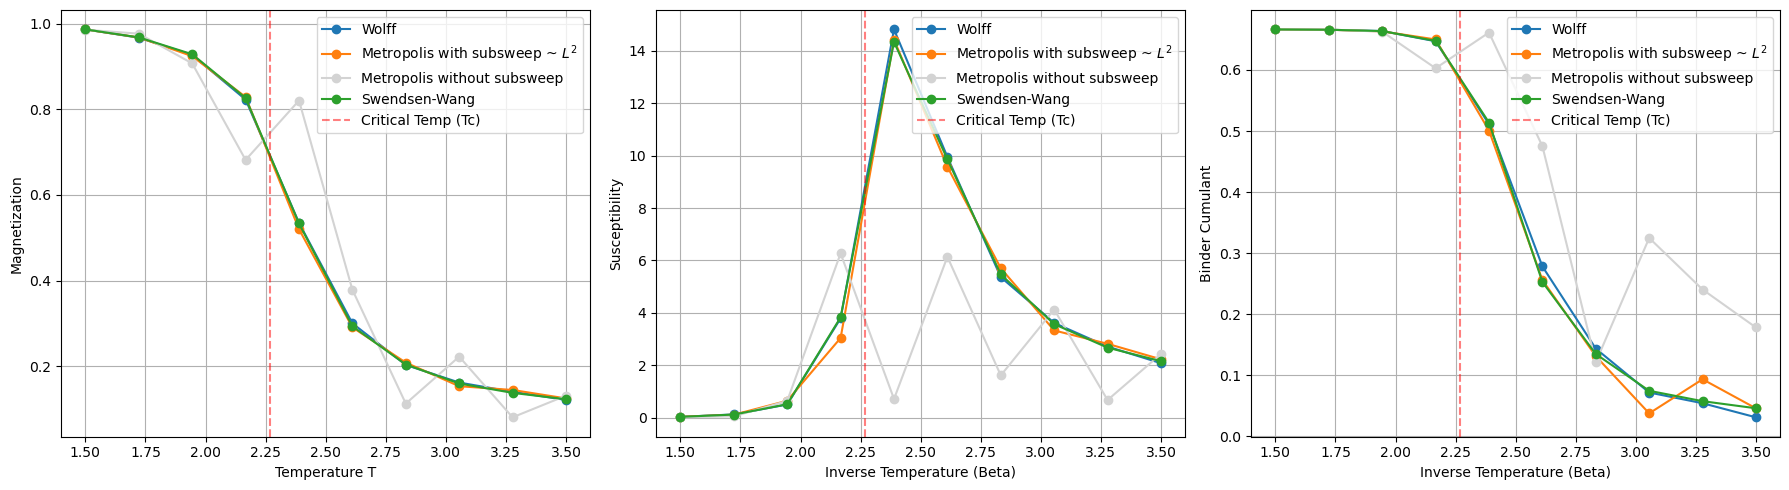

Runtime for Wolff: 5.9762 seconds
MC_speed for temperature 1.869 and system size 16 and for Wolff
3530.891937866521
Runtime for Wolff: 5.4293 seconds
MC_speed for temperature 2.069 and system size 16 and for Wolff
3343.309093168973
Runtime for Wolff: 3.8851 seconds
MC_speed for temperature 2.269 and system size 16 and for Wolff
1875.3975133300173
Runtime for Wolff: 2.2320 seconds
MC_speed for temperature 2.469 and system size 16 and for Wolff
1800.8606306476381
Runtime for Wolff: 0.7633 seconds
MC_speed for temperature 2.669 and system size 16 and for Wolff
6480.896907284045


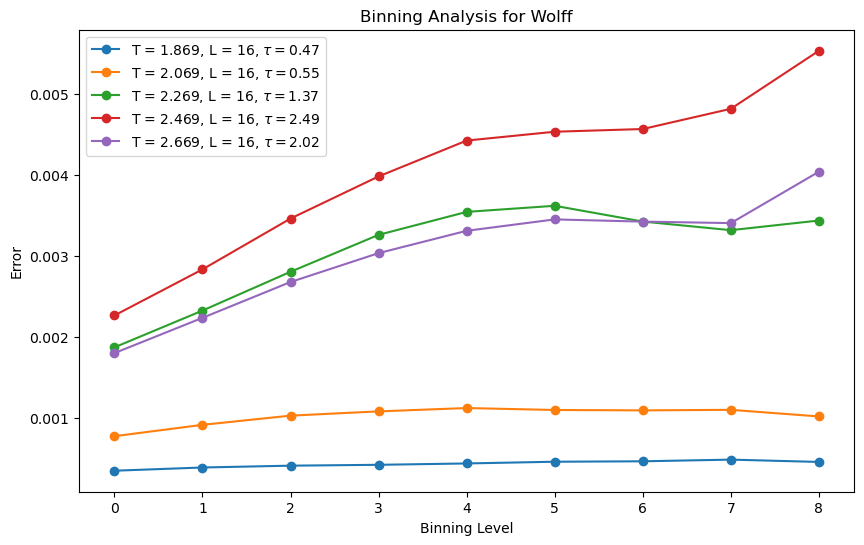

Runtime for Metropolis: 9.4196 seconds
MC_speed for temperature 1.869 and system size 16 and for Metropolis
325.9882175189879
Runtime for Metropolis: 10.7126 seconds
MC_speed for temperature 2.069 and system size 16 and for Metropolis
90.7700476914357
Runtime for Metropolis: 11.5489 seconds
MC_speed for temperature 2.269 and system size 16 and for Metropolis
29.10310269044978
Runtime for Metropolis: 11.8769 seconds
MC_speed for temperature 2.469 and system size 16 and for Metropolis
30.419583890598023
Runtime for Metropolis: 12.7786 seconds
MC_speed for temperature 2.669 and system size 16 and for Metropolis
74.53085272018718


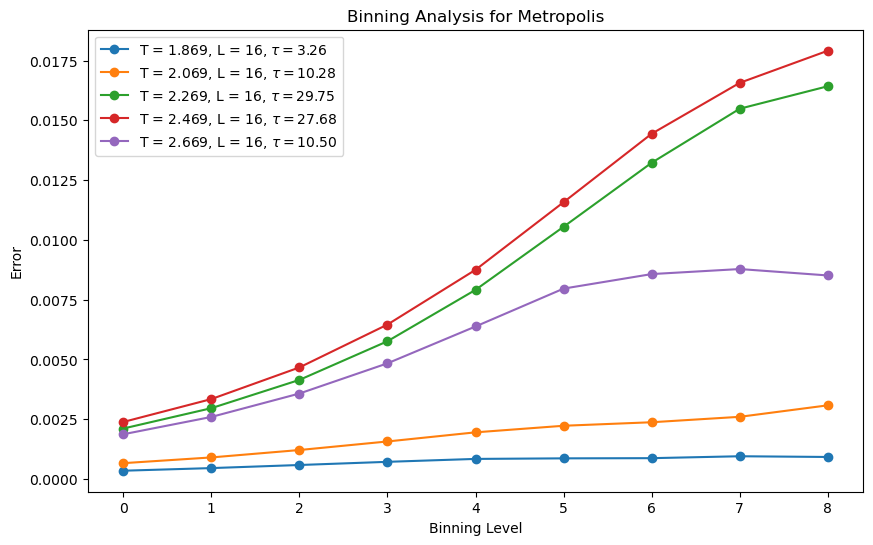

Runtime for Metropolis (no sweep): 0.0409 seconds
MC_speed for temperature 1.869 and system size 16 and for Metropolis (no subsweeps)
2265.449984697745
Runtime for Metropolis (no sweep): 0.0486 seconds
MC_speed for temperature 2.069 and system size 16 and for Metropolis (no subsweeps)
1812.1765055992169
Runtime for Metropolis (no sweep): 0.0412 seconds
MC_speed for temperature 2.269 and system size 16 and for Metropolis (no subsweeps)
1847.4583164337866
Runtime for Metropolis (no sweep): 0.0588 seconds
MC_speed for temperature 2.469 and system size 16 and for Metropolis (no subsweeps)
1269.383497252778
Runtime for Metropolis (no sweep): 0.0495 seconds
MC_speed for temperature 2.669 and system size 16 and for Metropolis (no subsweeps)
1604.8187481744287


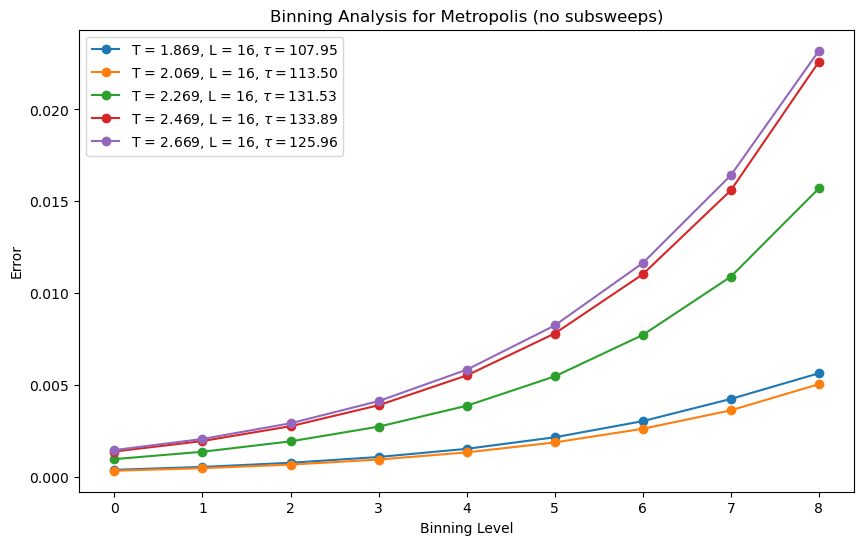

Runtime for SwendsenWang: 13.0149 seconds
MC_speed for temperature 1.869 and system size 16 and for SwendsenWang
420.71482959239734
Runtime for SwendsenWang: 9.7626 seconds
MC_speed for temperature 2.069 and system size 16 and for SwendsenWang
426.8293883483934
Runtime for SwendsenWang: 10.8694 seconds
MC_speed for temperature 2.269 and system size 16 and for SwendsenWang
339.6025261683869
Runtime for SwendsenWang: 11.3078 seconds
MC_speed for temperature 2.469 and system size 16 and for SwendsenWang
435.8010376897369
Runtime for SwendsenWang: 11.6973 seconds
MC_speed for temperature 2.669 and system size 16 and for SwendsenWang
1225.5137615387507


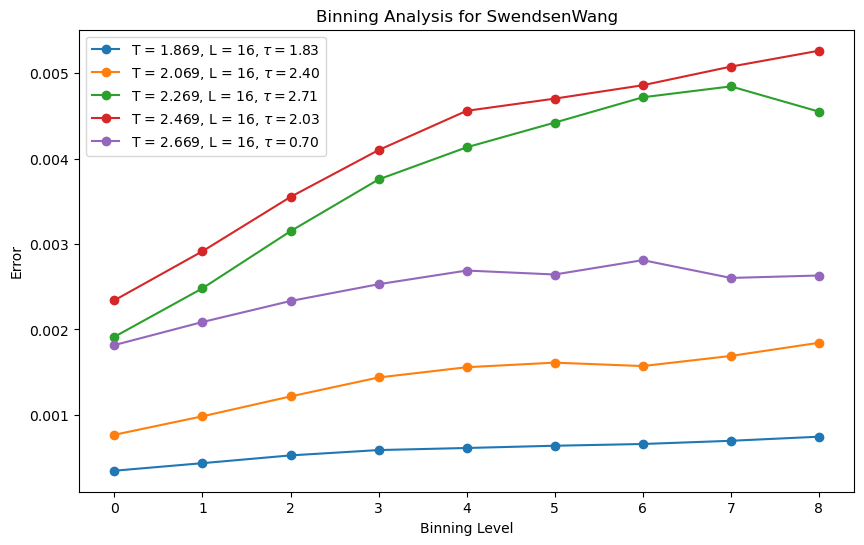

Runtime for Wolff: 1.1875 seconds
MC_speed for temperature 2.269 and system size 8 and for Wolff
7755.086151985692
Runtime for Wolff: 1.6008 seconds
MC_speed for temperature 2.269 and system size 10 and for Wolff
3834.331500926884
Runtime for Wolff: 2.1950 seconds
MC_speed for temperature 2.269 and system size 12 and for Wolff
3208.586229987893
Runtime for Wolff: 3.4159 seconds
MC_speed for temperature 2.269 and system size 14 and for Wolff
1400.6060918796247
Runtime for Wolff: 3.6436 seconds
MC_speed for temperature 2.269 and system size 16 and for Wolff
1545.9207462244617


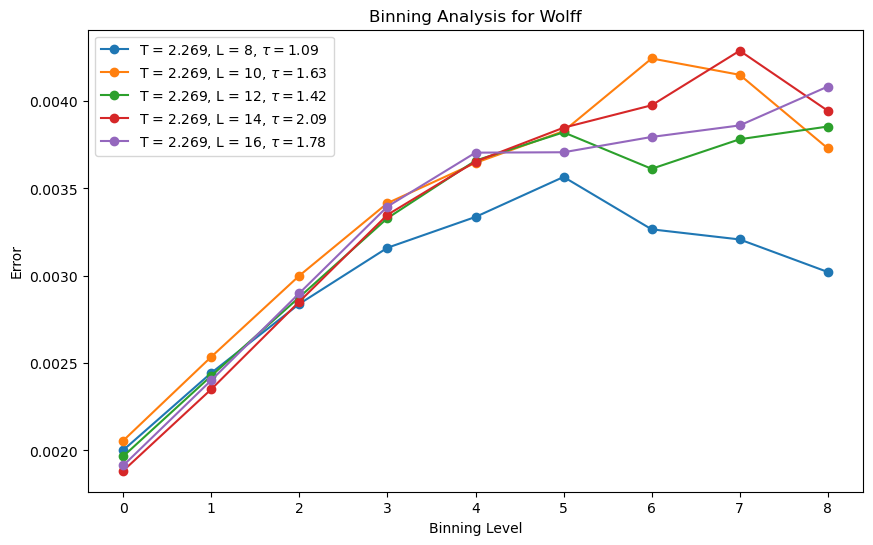

Runtime for Metropolis: 2.3200 seconds
MC_speed for temperature 2.269 and system size 8 and for Metropolis
631.5245618448364
Runtime for Metropolis: 3.5234 seconds
MC_speed for temperature 2.269 and system size 10 and for Metropolis
260.46528680388906
Runtime for Metropolis: 5.6817 seconds
MC_speed for temperature 2.269 and system size 12 and for Metropolis
85.80413638965238
Runtime for Metropolis: 6.9049 seconds
MC_speed for temperature 2.269 and system size 14 and for Metropolis
53.035900113071605


In [ ]:
# Parameters
L = 16 # Lattice size
Tc = 2.269 # critical temperature
Nsteps = 10000  # Number of updates 
n0 = 10**4 # thermalization steps
Ts = np.linspace(1.5, 3.5, 10)  # Temperature range around Tc

# create empty lists to store magnetization, susceptibility and binder cumulant
M_list_wolff = []
chi_list_wolff = []
U_list_wolff = []

M_list_metropolis_sweep = []
chi_list_metropolis_sweep = []
U_list_metropolis_sweep = []

M_list_metropolis = []
chi_list_metropolis = []
U_list_metropolis = []

M_list_sw = []
chi_list_sw = []
U_list_sw = []

# run simulation over temperatures
for T in Ts:
    print('-' * 25)
    print(f'Running for temperature {T} and system size {L}')
    
    model = IsingMC_Wolff(L, T)
    _, M_mean, chi, U, _  = compute_observables(model, Nsteps, n0, 'Wolff')
    M_list_wolff.append(M_mean) 
    chi_list_wolff.append(chi)
    U_list_wolff.append(U)
    
    model = IsingMC_Metropolis(L, T)
    _, M_mean, chi, U, _  = compute_observables(model, Nsteps, n0, 'Metropolis')   
    M_list_metropolis_sweep.append(M_mean) 
    chi_list_metropolis_sweep.append(chi)
    U_list_metropolis_sweep.append(U)
    
    model = IsingMC_Metropolis(L, T)
    _, M_mean, chi, U, _  = compute_observables(model, Nsteps, n0, 'Metropolis', skip = False)   
    M_list_metropolis.append(M_mean) 
    chi_list_metropolis.append(chi)
    U_list_metropolis.append(U)
    
    model = IsingMC_SwendsenWang(L, T)
    _, M_mean, chi, U, _  = compute_observables(model, Nsteps, n0, 'SwendsenWang')
    M_list_sw.append(M_mean)  
    chi_list_sw.append(chi)
    U_list_sw.append(U)


# plot results for comparison
plot_results(Ts, M_list_wolff, chi_list_wolff, U_list_wolff ,M_list_metropolis_sweep, chi_list_metropolis_sweep, U_list_metropolis_sweep, M_list_metropolis, chi_list_metropolis, U_list_metropolis, M_list_sw, chi_list_sw, U_list_sw )

# Task 3: compare the critical slowdown of both algorithms by computing the linear correlation time
# I use binning analysis to compute the linear correlation time.
# We also want to compare the performance of the both algorithms. To do that, I measure the runtime.
T_bin = [1.869, 2.069, Tc, 2.469, 2.669]
L_bin= [8, 10, 12, 14, 16]

# binning analysis for a range of temperatures
plot_binning_analysis(T_bin, [L], Nsteps, n0)
plot_binning_analysis(T_bin, [L], Nsteps, n0, 'Metropolis')
plot_binning_analysis(T_bin, [L], Nsteps, n0, 'Metropolis', False)
plot_binning_analysis(T_bin, [L], Nsteps, n0, 'SwendsenWang')

# binning analysis for a range of sizes
plot_binning_analysis([Tc], L_bin, Nsteps, n0)
plot_binning_analysis([Tc], L_bin, Nsteps, n0, 'Metropolis')
plot_binning_analysis([Tc], L_bin, Nsteps, n0, 'Metropolis', False)
plot_binning_analysis([Tc], L_bin, Nsteps, n0, 'SwendsenWang')

# binning analysis for different algorithms
plot_binning_analysis_combined([Tc], [16], Nsteps, n0)
